# Анализ Retention для Superstore

Этот проект возник, когда я строил дашборд Анализ Продаж по данным Superstore  
Я увидел, что продажи магазина растут и решил разобраться - за счет чего происходит этот рост.  
В этом проекте я: 
* Выявил проблему привлечения новых покупателей  
* Провел анализ Retention  
* Выявил наличие долгосрочного Retention Rate  
* Провел Когортный Анализ
* Выявил резкое падение Retention во всех когортах на первый месяц и хорошую возвращаемость на 5-6 месяц


In [91]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import seaborn as sns

In [92]:
sns.set(font_scale=2,
        style    ='whitegrid',
        rc       ={'figure.figsize': (20,7)}
       )

In [93]:
data = pd.read_excel('Sample - Superstore - RU.xlsx')
data.head()

,Категория,Город,Страна,Имя заказчика,Скидка,Дата заказа,ID заказа,Специалист,Почтовый код,Название продукта,...,Количество,Тип Региона,Продажи,Сегмент,Дата доставки,Тип доставки,Область,Подкатегория,Стоимость доставки,Country
0,Мебель,Барнаул,Россия,Claire Gute,0.00,2018-11-08,CA-2018-152156,Cassandra Brandow,42420.0,Bush Somerset Collection Bookcase,...,2,Южный,28141.944,Потребительский,2018-11-11,Второй класс,Алтайский край,Книжные шкафы,8891,Russia
1,Мебель,Барнаул,Россия,Claire Gute,0.00,2018-11-08,CA-2018-152156,Cassandra Brandow,42420.0,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",...,3,Южный,76586.232,Потребительский,2018-11-11,Второй класс,Алтайский край,Стулья,19293,Russia
2,Мебель,Благовещенск,Россия,Sean O'Donnell,0.45,2017-10-11,US-2017-108966,Cassandra Brandow,33311.0,Bretford CR4500 Series Slim Rectangular Table,...,5,Южный,104239.980,Потребительский,2017-10-18,Стандартный класс,Амурская область,Столы,93403,Russia
3,Канцтовары,Благовещенск,Россия,Sean O'Donnell,0.20,2017-10-11,US-2017-108966,Cassandra Brandow,33311.0,Eldon Fold 'N Roll Cart System,...,2,Южный,2356.002,Потребительский,2017-10-18,Стандартный класс,Амурская область,Накопители,1079,Russia
4,Канцтовары,Благовещенск,Россия,Erin Smith,0.20,2019-09-19,CA-2019-139619,Cassandra Brandow,32935.0,"Advantus 10-Drawer Portable Organizer, Chrome ...",...,2,Южный,10183.488,Корпоративный,2019-09-23,Стандартный класс,Амурская область,Накопители,5711,Russia


## Анализ продаж

In [94]:
data['Месяц заказа'] = data['Дата заказа'].dt.to_period('M')


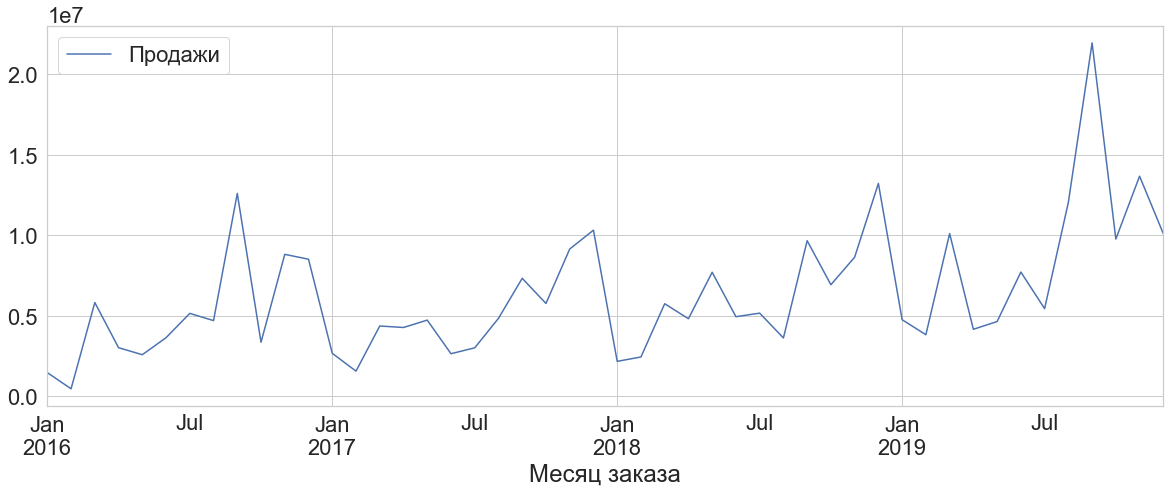

In [95]:
data.groupby('Месяц заказа')\
    .agg({'Продажи':'sum'}).plot()
plt.show()

  
  
Общие продажи продажи имеют тенденцию на рост, посмотрим на разбивку по категориям  
  
  

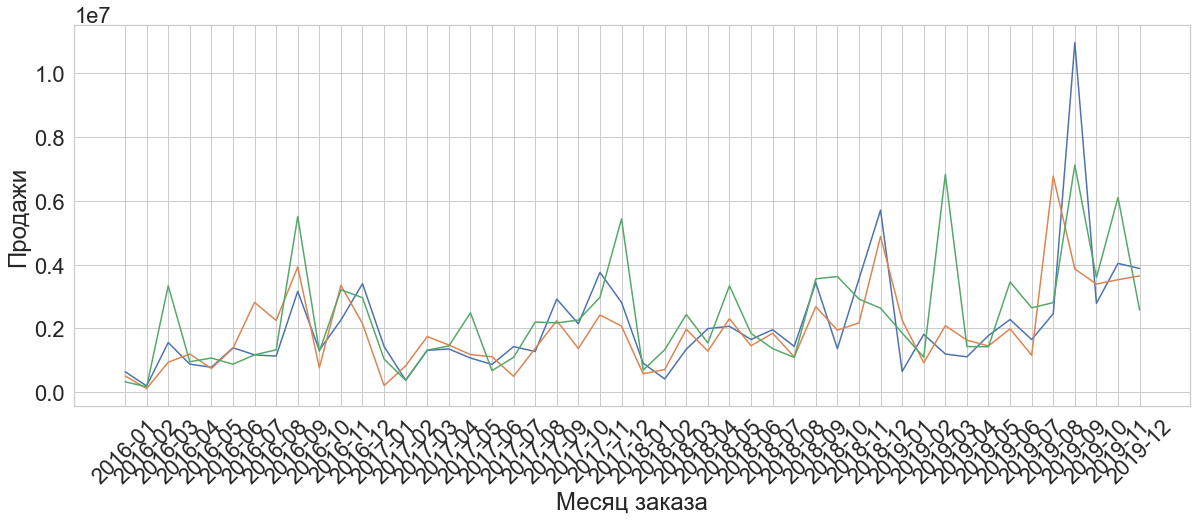

In [96]:

for i, cat in enumerate(data['Категория'].unique()):
    cur_data= data[data['Категория'] == cat].groupby('Месяц заказа')\
                    .agg({'Продажи':'sum'})\
                    .reset_index()
    cur_data['Месяц заказа']= cur_data['Месяц заказа'].astype('string')
    plt.xticks(rotation=45)
    sns.lineplot(data = cur_data, x='Месяц заказа', y='Продажи')
 

Видим, что продажи внутри категорий, действительно, не падают, а даже имеют тенденцию на рост.  
Посмотрим на число новых пользователей по месяцам и поймем, за счет какой аудитории наш магазин остается на плаву - новой или удержанной? 

## Анализ числа новых покупателей

Мы хотим понять, за счет чего 

In [97]:
# для каждого заказчика заимели дату, когда он пришел впервые

customer_in = data.groupby('Имя заказчика')\
                .agg({'Дата заказа':'min', 'Продажи':'sum'})\
                .reset_index()\
                .rename(columns = {'Дата заказа': 'Дата начала'})
customer_in

,Имя заказчика,Дата начала,Продажи
0,Aaron Bergman,2016-02-18,92213.960
1,Aaron Hawkins,2016-04-22,183721.086
2,Aaron Smayling,2016-07-27,317196.233
3,Adam Bellavance,2017-09-18,807475.593
4,Adam Hart,2016-11-16,342195.687
...,...,...,...
792,Yoseph Carroll,2016-11-17,575170.192
793,Zuschuss Carroll,2016-10-13,885706.918
794,Zuschuss Donatelli,2016-08-27,205428.832
795,Тихвин Blackwell,2018-03-29,47672.648


In [98]:
customer_in['Дата начала'].dt.to_period('M')\
                            .value_counts()\
                            .reset_index()\
                            .sort_values('index',ascending=True)

,index,Дата начала
10,2016-01,32
11,2016-02,24
1,2016-03,65
3,2016-04,56
4,2016-05,56
7,2016-06,48
8,2016-07,44
6,2016-08,49
0,2016-09,68
9,2016-10,42


In [99]:
customer_in['Год начала'] = customer_in['Дата начала'].dt.to_period('Y')

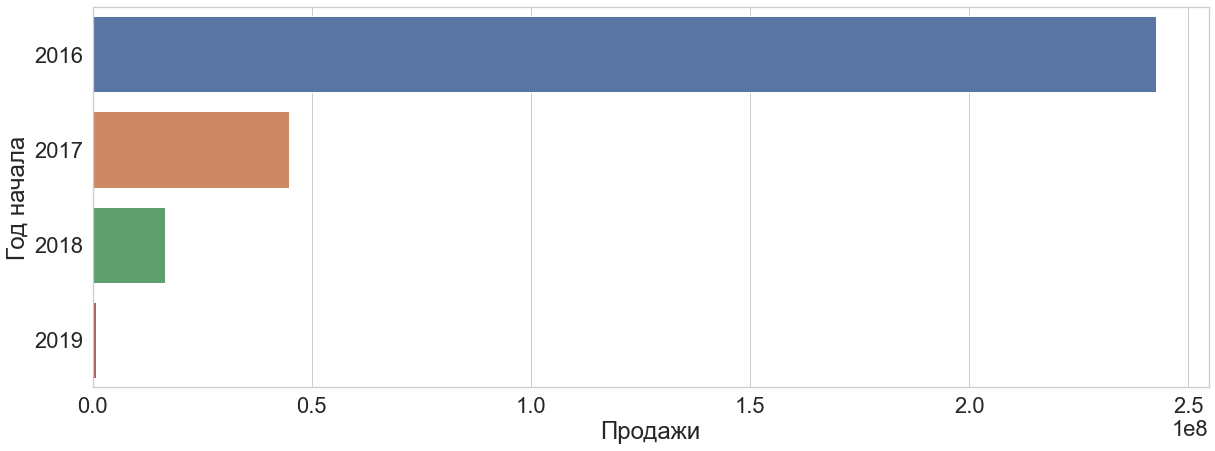

In [100]:
Sales_by_StartYear = customer_in.groupby('Год начала')\
                .agg({'Продажи': 'sum'})\
                .reset_index()
Sales_by_StartYear
sns.barplot(data = Sales_by_StartYear, y='Год начала' , x = 'Продажи' )
plt.show()

  
Видим, что основое число привлеченных клиентов приходится на 2016 год и 2017 года  
Точно также обстоят дела с продажами по клиентам, привлеченным в этих годах. Основные продажи приходятся на них.    

Посмотрим, как устроен Retention в нашем магазине  
  


## Анализ Retention

Посмотрим, как устроено удержание самых профитных клиентов - пришедших за первый год

In [101]:
data.head()

,Категория,Город,Страна,Имя заказчика,Скидка,Дата заказа,ID заказа,Специалист,Почтовый код,Название продукта,...,Тип Региона,Продажи,Сегмент,Дата доставки,Тип доставки,Область,Подкатегория,Стоимость доставки,Country,Месяц заказа
0,Мебель,Барнаул,Россия,Claire Gute,0.00,2018-11-08,CA-2018-152156,Cassandra Brandow,42420.0,Bush Somerset Collection Bookcase,...,Южный,28141.944,Потребительский,2018-11-11,Второй класс,Алтайский край,Книжные шкафы,8891,Russia,2018-11
1,Мебель,Барнаул,Россия,Claire Gute,0.00,2018-11-08,CA-2018-152156,Cassandra Brandow,42420.0,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",...,Южный,76586.232,Потребительский,2018-11-11,Второй класс,Алтайский край,Стулья,19293,Russia,2018-11
2,Мебель,Благовещенск,Россия,Sean O'Donnell,0.45,2017-10-11,US-2017-108966,Cassandra Brandow,33311.0,Bretford CR4500 Series Slim Rectangular Table,...,Южный,104239.980,Потребительский,2017-10-18,Стандартный класс,Амурская область,Столы,93403,Russia,2017-10
3,Канцтовары,Благовещенск,Россия,Sean O'Donnell,0.20,2017-10-11,US-2017-108966,Cassandra Brandow,33311.0,Eldon Fold 'N Roll Cart System,...,Южный,2356.002,Потребительский,2017-10-18,Стандартный класс,Амурская область,Накопители,1079,Russia,2017-10
4,Канцтовары,Благовещенск,Россия,Erin Smith,0.20,2019-09-19,CA-2019-139619,Cassandra Brandow,32935.0,"Advantus 10-Drawer Portable Organizer, Chrome ...",...,Южный,10183.488,Корпоративный,2019-09-23,Стандартный класс,Амурская область,Накопители,5711,Russia,2019-09


In [102]:
data = data[['Имя заказчика','Дата заказа','ID заказа']]

In [103]:
#Получили верхнюю границу даты для анализа 
date_year_delay = customer_in['Дата начала'].min() + timedelta(days = 365)
date_year_delay

Timestamp('2017-01-02 00:00:00')

In [104]:
# получили датасет пришедших за первый год заказчиков и дату ихх первого заказа
customer_in_firstyear = customer_in[customer_in['Дата начала'] < date_year_delay]
customer_in_firstyear

,Имя заказчика,Дата начала,Продажи,Год начала
0,Aaron Bergman,2016-02-18,92213.960,2016
1,Aaron Hawkins,2016-04-22,183721.086,2016
2,Aaron Smayling,2016-07-27,317196.233,2016
4,Adam Hart,2016-11-16,342195.687,2016
5,Adam Shillingsburg,2016-09-22,336978.333,2016
...,...,...,...,...
789,William Brown,2016-11-04,2665384.438,2016
790,Xylona Preis,2016-01-20,272814.532,2016
792,Yoseph Carroll,2016-11-17,575170.192,2016
793,Zuschuss Carroll,2016-10-13,885706.918,2016


In [105]:
data = pd.merge(data,customer_in_firstyear, on='Имя заказчика' )
data.head()

,Имя заказчика,Дата заказа,ID заказа,Дата начала,Продажи,Год начала
0,Erin Smith,2019-09-19,CA-2019-139619,2016-10-02,552649.803,2016
1,Erin Smith,2018-07-14,CA-2018-136924,2016-10-02,552649.803,2016
2,Erin Smith,2018-12-19,CA-2018-134936,2016-10-02,552649.803,2016
3,Erin Smith,2016-10-02,CA-2016-108189,2016-10-02,552649.803,2016
4,Erin Smith,2016-10-02,CA-2016-108189,2016-10-02,552649.803,2016


In [106]:
#получим число месяцев с первой покупки
data['Месяцев с первого заказа'] = np.floor((data['Дата заказа'] - data['Дата начала']) / np.timedelta64(1, 'M'))

In [107]:
#оставим только данные о покупках за первый год
data = data[data['Дата заказа'] <= data['Дата начала'].min() + timedelta(days = 365)]


In [114]:
first_year_retention = data[['Имя заказчика','Месяцев с первого заказа' ]]
first_year_retention.sample(10)

,Имя заказчика,Месяцев с первого заказа
4433,Ted Trevino,0.0
9743,Berenike Kampe,4.0
1750,Ken Black,0.0
4207,Tim Brockman,0.0
1077,Jeremy Pistek,0.0
5070,Craig Molinari,6.0
2799,Stephanie Phelps,3.0
6907,Russell D'Ascenzo,0.0
4546,Charles Crestani,0.0
2017,Randy Ferguson,0.0


In [115]:
first_year_retention = first_year_retention.groupby('Месяцев с первого заказа')\
                    .agg({'Имя заказчика': 'nunique'})\
                    .reset_index()
first_year_retention

,Месяцев с первого заказа,Имя заказчика
0,0.0,597
1,1.0,46
2,2.0,43
3,3.0,38
4,4.0,29
5,5.0,36
6,6.0,32
7,7.0,31
8,8.0,21
9,9.0,9


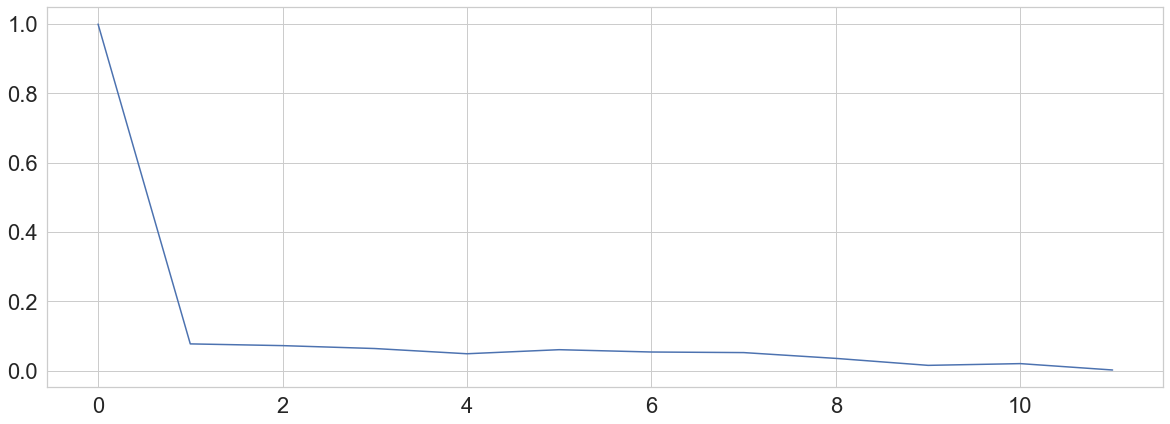

In [116]:
plt.plot(first_year_retention['Месяцев с первого заказа'], first_year_retention['Имя заказчика']/first_year_retention['Имя заказчика'][0])

plt.show()

Видим резкое падение возвращаемости на первый же месяц, но зато в течение года люди так или иначе возвращались и можно говорить о долгосрочном retention

In [117]:
data['Месяц начала'] = data['Дата начала'].dt.to_period('M')
data.head()

,Имя заказчика,Дата заказа,ID заказа,Дата начала,Продажи,Год начала,Месяцев с первого заказа,Месяц начала
3,Erin Smith,2016-10-02,CA-2016-108189,2016-10-02,552649.803,2016,0.0,2016-10
4,Erin Smith,2016-10-02,CA-2016-108189,2016-10-02,552649.803,2016,0.0,2016-10
5,Erin Smith,2016-10-02,CA-2016-108189,2016-10-02,552649.803,2016,0.0,2016-10
6,Erin Smith,2016-10-02,CA-2016-108189,2016-10-02,552649.803,2016,0.0,2016-10
9,Erin Smith,2016-10-02,CA-2016-108189,2016-10-02,552649.803,2016,0.0,2016-10


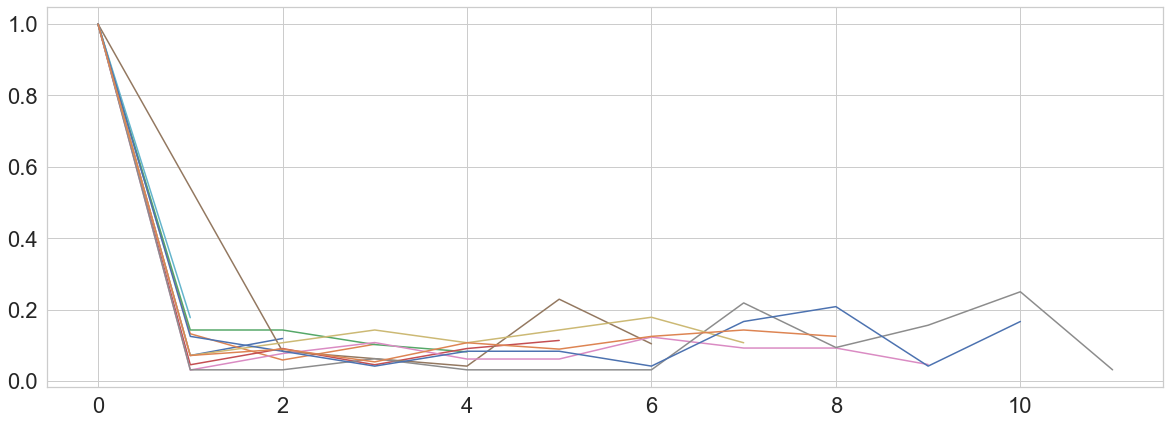

In [118]:
for i, month in enumerate(data['Месяц начала'].unique()):
    cur_data= data[data['Месяц начала'] == month].groupby('Месяцев с первого заказа')\
                    .agg({'Имя заказчика': 'nunique'})\
                    .reset_index()
    plt.plot(cur_data['Месяцев с первого заказа'], cur_data['Имя заказчика']/cur_data['Имя заказчика'][0])

In [119]:
data.head()

,Имя заказчика,Дата заказа,ID заказа,Дата начала,Продажи,Год начала,Месяцев с первого заказа,Месяц начала
3,Erin Smith,2016-10-02,CA-2016-108189,2016-10-02,552649.803,2016,0.0,2016-10
4,Erin Smith,2016-10-02,CA-2016-108189,2016-10-02,552649.803,2016,0.0,2016-10
5,Erin Smith,2016-10-02,CA-2016-108189,2016-10-02,552649.803,2016,0.0,2016-10
6,Erin Smith,2016-10-02,CA-2016-108189,2016-10-02,552649.803,2016,0.0,2016-10
9,Erin Smith,2016-10-02,CA-2016-108189,2016-10-02,552649.803,2016,0.0,2016-10


In [120]:
data['Дата начала'].min().month

1

In [121]:
data['Когортный индекс'] = data['Дата заказа'].dt.month - data['Дата начала'].min().month

In [122]:
data[data['Месяц начала'] == '2016-12']

,Имя заказчика,Дата заказа,ID заказа,Дата начала,Продажи,Год начала,Месяцев с первого заказа,Месяц начала,Когортный индекс
104,Mike Kennedy,2016-12-19,US-2016-150574,2016-12-19,154878.971,2016,0.0,2016-12,11
105,Mike Kennedy,2016-12-19,US-2016-150574,2016-12-19,154878.971,2016,0.0,2016-12,11
106,Mike Kennedy,2016-12-19,US-2016-150574,2016-12-19,154878.971,2016,0.0,2016-12,11
107,Mike Kennedy,2016-12-19,US-2016-150574,2016-12-19,154878.971,2016,0.0,2016-12,11
246,Steve Chapman,2016-12-16,CA-2016-151379,2016-12-16,267282.500,2016,0.0,2016-12,11
...,...,...,...,...,...,...,...,...,...
9830,Maureen Gnade,2016-12-26,CA-2016-139598,2016-12-26,144568.276,2016,0.0,2016-12,11
9831,Maureen Gnade,2016-12-26,CA-2016-139598,2016-12-26,144568.276,2016,0.0,2016-12,11
9871,David Kendrick,2016-12-05,CA-2016-166191,2016-12-05,86044.154,2016,0.0,2016-12,11
9872,David Kendrick,2016-12-05,CA-2016-166191,2016-12-05,86044.154,2016,0.0,2016-12,11


In [123]:
data['Месяц начала'] = data['Дата начала'].dt.to_period('M')

In [124]:
pivot_data=data.groupby(['Месяц начала','Месяцев с первого заказа'])\
                    .agg({'Имя заказчика':'nunique'})\
                    .reset_index()
pivot_data = pivot_data.pivot_table(index='Месяц начала', columns='Месяцев с первого заказа', values='Имя заказчика')
pivot_data

Месяцев с первого заказа,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0
Месяц начала,,,,,,,,,,,,
2016-01,32.0,1.0,1.0,2.0,1.0,1.0,1.0,7.0,3.0,5.0,8.0,1.0
2016-02,24.0,3.0,2.0,1.0,2.0,2.0,1.0,4.0,5.0,1.0,4.0,NaN
2016-03,65.0,2.0,5.0,7.0,4.0,4.0,8.0,6.0,6.0,3.0,NaN,NaN
2016-04,56.0,4.0,5.0,3.0,6.0,5.0,7.0,8.0,7.0,NaN,NaN,NaN
2016-05,56.0,4.0,6.0,8.0,6.0,8.0,10.0,6.0,NaN,NaN,NaN,NaN
2016-06,48.0,NaN,4.0,3.0,2.0,11.0,5.0,NaN,NaN,NaN,NaN,NaN
2016-07,44.0,2.0,4.0,2.0,4.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN
2016-08,49.0,7.0,7.0,5.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-09,68.0,9.0,4.0,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [125]:
data[data['Месяц начала'] =='2016-12']['Имя заказчика'].nunique()

51

In [126]:
cohort_totals = pivot_data.iloc[:,0]
pivot_data = pivot_data.divide(cohort_totals, axis=0)

In [127]:
pivot_data

Месяцев с первого заказа,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0
Месяц начала,,,,,,,,,,,,
2016-01,1.0,0.031250,0.031250,0.062500,0.031250,0.031250,0.031250,0.218750,0.093750,0.156250,0.250000,0.03125
2016-02,1.0,0.125000,0.083333,0.041667,0.083333,0.083333,0.041667,0.166667,0.208333,0.041667,0.166667,NaN
2016-03,1.0,0.030769,0.076923,0.107692,0.061538,0.061538,0.123077,0.092308,0.092308,0.046154,NaN,NaN
2016-04,1.0,0.071429,0.089286,0.053571,0.107143,0.089286,0.125000,0.142857,0.125000,NaN,NaN,NaN
2016-05,1.0,0.071429,0.107143,0.142857,0.107143,0.142857,0.178571,0.107143,NaN,NaN,NaN,NaN
2016-06,1.0,NaN,0.083333,0.062500,0.041667,0.229167,0.104167,NaN,NaN,NaN,NaN,NaN
2016-07,1.0,0.045455,0.090909,0.045455,0.090909,0.113636,NaN,NaN,NaN,NaN,NaN,NaN
2016-08,1.0,0.142857,0.142857,0.102041,0.081633,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-09,1.0,0.132353,0.058824,0.102941,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


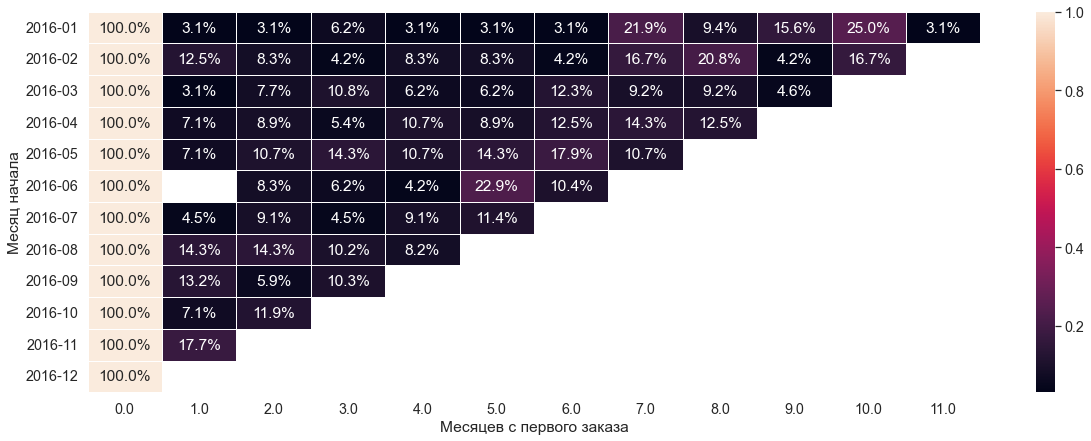

In [128]:
sns.set(font_scale=1.3,
        style    ='whitegrid',
        rc       ={'figure.figsize': (20,7)}
       )
#plt.title('Cohort analysis-Rates')
sns.heatmap(data=pivot_data, annot=True, fmt=".1%",linewidth=1)
plt.show()

Выводы:
1) Видим флуктационное поведение возвращаемости покупателей. Это может быть обусловлено тем, что данных мало либо они не очень качественно сгенерированы :)  

2) Видим резкое падение retention в первый же месяц, но затем метрика остается на уровне 5-10 % , что может для нас означать наличие долгосрочного retention rate  

3) По данным видно резкое снижение новых покупателей , но показатели продаж не проседают, это обусловненно тем, что люди пришедшие к нам в 2016 и 2017 оставались нашими клиентами и к 2019 году. Это означает, что они видят ценность продукта и с удержанием всё хорошо. Нужно работать над маркетингом, над привлечением